
# Calendar Averaging

This script illustrates using geocat-comp's [calendar_average](https://geocat-comp.readthedocs.io/en/stable/user_api/generated/geocat.comp.climatologies.calendar_average.html) function to compute daily, monthly, and seasonal calendar averages of raw surface temperature data from a 6-hour temporal resolution model.

In [1]:
import cftime
import matplotlib.pyplot as plt
import xarray as xr
import nc_time_axis

from geocat.comp import calendar_average
import geocat.datafiles as gdf

## Read in data

We will get the data from the [geocat-datafiles](https://github.com/NCAR/geocat-datafiles) package. This package contains example data used in many of the examples for geocat packages.

Then, we use xarray's [open_dataset](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html) function to read the data into an xarray dataset, choose a single model from the ensemble run, and extract its surface temperature data into `temp`

In [2]:
ds = xr.open_dataset(gdf.get('netcdf_files/atm.20C.hourly6-1990-1995-TS.nc'))
ds = ds.isel(member_id=0)  # select one model from the ensemble

temp = ds.TS  # surface temperature data

Let's take a look at the raw surface temperature data.

Text(0.5, 0, 'Time')

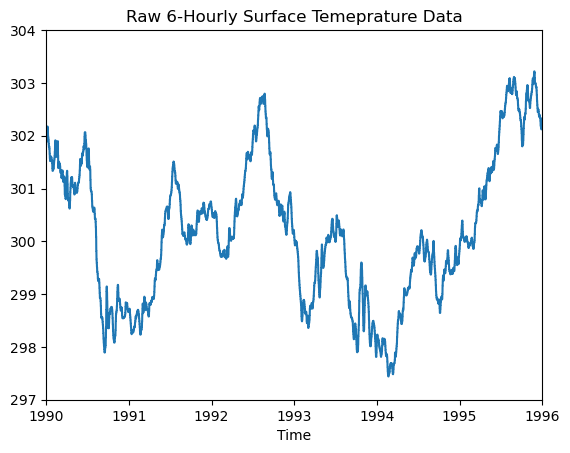

In [3]:
# Convert datetimes to number of hours since 1990-01-01 00:00:00
# This must be done in order to use the time for the x axistim
time_num_raw = cftime.date2num(temp.time, 'hours since 1990-01-01 00:00:00')

# Start and end time for axes limits in units of hours since 1990-01-01 00:00:00
tstart = time_num_raw[0]
tend = time_num_raw[-1]

# Plot
plt.plot(time_num_raw, temp.data)

plt.xlim(tstart, tend)
plt.xticks(ticks=range(tstart, tend + 1, 365 * 24), labels=range(1990, 1997));
plt.ylim(297, 304)

plt.title("Raw 6-Hourly Surface Temperature Data")
plt.xlabel("Time")

## Calculate daily, monthly, and seasonal averages using `calendar_average`

First we'll compute the daily calendar average of the raw surface temperature using the `calendar_average` function with the `freq` argument set to `day`. This function averages all data points within each 24-hour period.

Text(0.5, 0, 'Time')

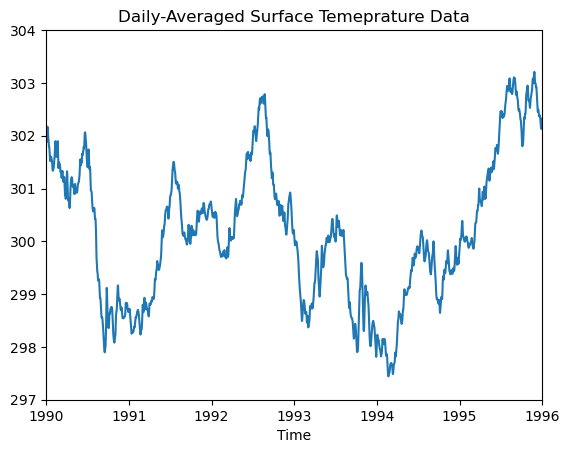

In [4]:
# Compute Daily
daily = calendar_average(temp, freq='day')

time_num_day = cftime.date2num(daily.time, 'hours since 1990-01-01 00:00:00')

# Plot
plt.plot(time_num_day, daily.data)

plt.xlim(tstart, tend)
plt.xticks(ticks=range(tstart, tend + 1, 365 * 24), labels=range(1990, 1997));
plt.ylim(297, 304)

plt.title("Daily-Averaged Surface Temperature Data")
plt.xlabel("Time")

Next, we'll look at a monthly calendar average by setting the `freq` argument of `calendar_average` to `month`. Since the data is now grouped by month, the plot produces a smoother curve.

Text(0.5, 0, 'Time')

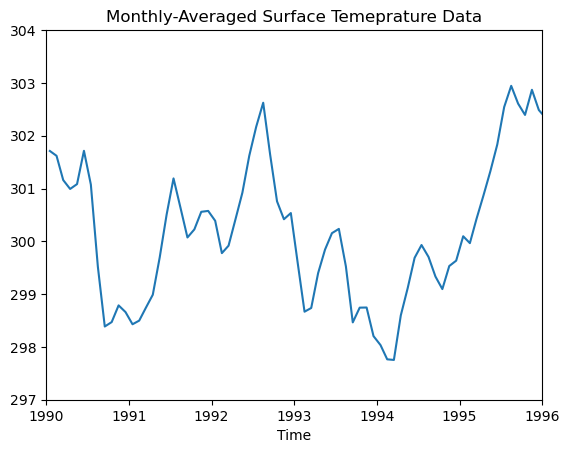

In [5]:
# Compute Monthly
monthly = calendar_average(temp, freq='month')

time_num_month = cftime.date2num(monthly.time,
                                 'hours since 1990-01-01 00:00:00')

# Plot
plt.plot(time_num_month, monthly.data)

plt.xlim(tstart, tend)
plt.xticks(ticks=range(tstart, tend + 1, 365 * 24), labels=range(1990, 1997));
plt.ylim(297, 304)

plt.title("Monthly-Averaged Surface Temperature Data")
plt.xlabel("Time")


And finally, let's look at a seasonal calendar average of the surface temperature data by setting the `freq` argument of `calendar_average` to `season`. This averages all data points in each meteorological season. Those seasons are each comprised of three month periods with the first consisting of December, January, and February for meteorological winter. This yields an even smoother curve.

Text(0.5, 1.0, 'Seasonally-Averaged Surface Temeprature Data')

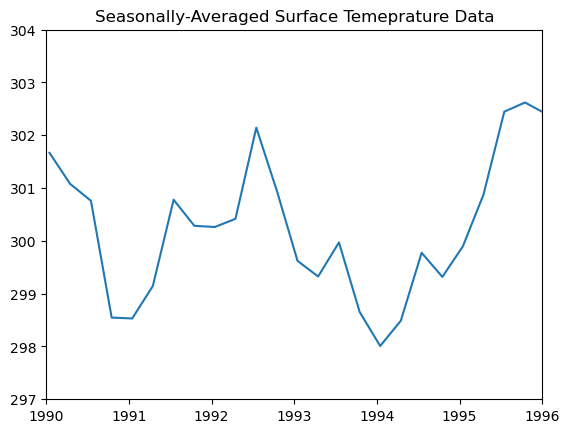

In [6]:
# Compute Seasonally
season = calendar_average(temp, freq='season')

time_num_season = cftime.date2num(season.time,
                                  'hours since 1990-01-01 00:00:00')

# Plot
plt.plot(time_num_season, season.data)

plt.xlim(tstart, tend)
plt.xticks(ticks=range(tstart, tend + 1, 365 * 24), labels=range(1990, 1997));
plt.ylim(297, 304)

plt.title("Seasonally-Averaged Surface Temperature Data")